In [9]:
import torch
import pandas as pd
import kagglehub
device = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))

NEUTRAL = "neutral"
BULLYING = "bullying"

print(f"device = {device}")

device = cpu


In [10]:
# Load the kaggle bullying dataset
KAGGLE_TABLE_NAME = "Approach to Social Media Cyberbullying and Harassment Detection Using Advanced Machine Learning.csv"

# Download latest version
path = kagglehub.dataset_download("saifulislam7/cyberbullying-and-harassment-detection-using-ml")
print("Path to dataset files:", path)
kaggle_df = pd.read_csv(path + "/" + KAGGLE_TABLE_NAME, index_col=0)
print(f"table size: {len(kaggle_df)}")
kaggle_df.head(10)

Path to dataset files: /home/yaron/.cache/kagglehub/datasets/saifulislam7/cyberbullying-and-harassment-detection-using-ml/versions/1
table size: 8452


,Label,Types
Text,,
Ten outside soon doctor shake everyone treatment seat radio land.,Not-Bullying,NaN
my life has come to a standstill and at this point.,Not-Bullying,NaN
girl this nigga make me sick to my stomach,Bullying,Ethnicity
I wanna fuck you,Bullying,Sexual
"Oh hey, you should be ashamed of your disgusting self",Not - Bullying,NaN
Haha isn't route running part of the position? People are dumb. But fuck edelman! He just looks like he says,Bullying,Ethnicity
Racism is when u select yur white clothes to wash first before the black and colored ones,Bullying,Ethnicity
Who are islamists? Those who fully follow the teachings of Muhammed found in the Quran and Hadiths,Bullying,Religion
Male action movies...ehhhh @That_Damn_Ram Not sexist but female action movies...ehhhh,Bullying,Religion


In [11]:
# Arrange the dataset a bit.
# Arrange columns names
kaggle_df["Text1"] = kaggle_df.index
kaggle_df.index = [i for i in range(len(kaggle_df))]
kaggle_df = kaggle_df.rename(columns={"Text1":"Text"})
kaggle_df = kaggle_df[["Text", "Label", "Types"]].reset_index(drop=True)

# Arrange labels and types content (make it canonical, avoid duplications)
kaggle_df.Types = kaggle_df.Types.apply(lambda x: NEUTRAL if pd.isna(x) else x)
kaggle_df.Label = kaggle_df.Label.apply(lambda x: NEUTRAL if not isinstance(x, str) else (NEUTRAL if "not" in x.lower() else BULLYING))

# Remove mis-match
print(f"initial table size: {len(kaggle_df)}")
kaggle_df = kaggle_df[kaggle_df.apply(lambda x: (x["Label"] == NEUTRAL and x["Types"] == NEUTRAL) or (x["Label"] == BULLYING and x["Types"] != NEUTRAL), axis=1)].reset_index(drop=True)
print(f"'clean' table size: {len(kaggle_df)}")
kaggle_df.head(20)

initial table size: 8452
'clean' table size: 8407


,Text,Label,Types
0,Ten outside soon doctor shake everyone treatme...,neutral,neutral
1,my life has come to a standstill and at this p...,neutral,neutral
2,girl this nigga make me sick to my stomach,bullying,Ethnicity
3,I wanna fuck you,bullying,Sexual
4,"Oh hey, you should be ashamed of your disgusti...",neutral,neutral
5,Haha isn't route running part of the position?...,bullying,Ethnicity
6,Racism is when u select yur white clothes to w...,bullying,Ethnicity
7,Who are islamists? Those who fully follow the ...,bullying,Religion
8,Male action movies...ehhhh @That_Damn_Ram Not ...,bullying,Religion
9,Wishing my arena partner was on.,neutral,neutral


table size: 8407
binary distribution:
	Label
bullying    4807
neutral     3600
Name: count, dtype: int64


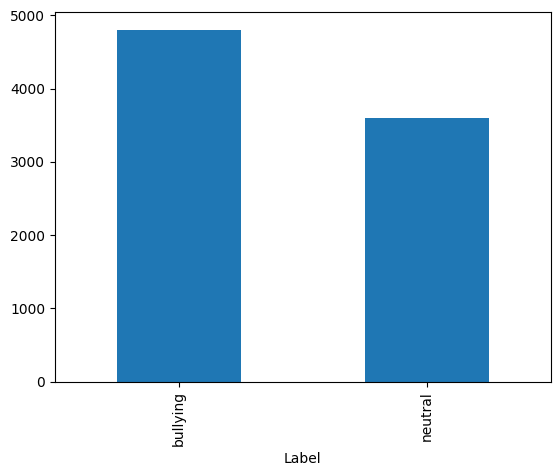

In [12]:
# Check binary distribution
print(f"table size: {len(kaggle_df)}")
print(f"binary distribution:\n\t{kaggle_df.Label.value_counts()}")
num_lables = sum([x for x in dict(kaggle_df.Label.value_counts()).values()])
kaggle_df.Label.value_counts().plot(kind="bar")
# Verify adequateness
assert num_lables  == len(kaggle_df), f"sizes miss match - there are {num_lables} labels, while the table size is {len(kaggle_df)}"

In [13]:
# Check multi class distribution
print(f"multi class distribution:\n\t{kaggle_df.Types.value_counts()}")

multi class distribution:
	Types
neutral        3600
Sexual          984
Troll           948
Political       734
Vocational      667
Religion        642
Threat          192
Ethnicity       169
Threats         157
Vocational       75
Religion         48
Religon          45
Sexual           36
Ethnicity        31
Threats          23
Political        20
Religious        10
Troll             7
sexual            6
Racism            4
political         3
Saxual            2
Vocation          2
Ethnically        1
Threat            1
Name: count, dtype: int64


fixed multi class distribution:



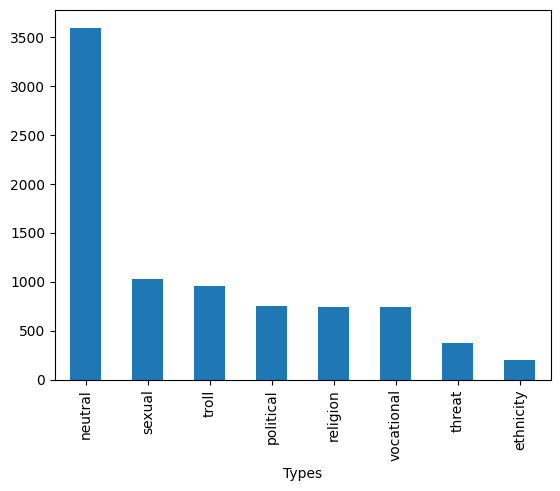

In [14]:
# Fix class names
kaggle_df.Types = kaggle_df.Types.apply(lambda x: x.strip())

# Convert into canonical names.
# Notice that 'racism' is converted into 'ethnicity', as there are only 4 cases
# of racism, and due to the proximity between racism and ethnicity.
conversion = {NEUTRAL: NEUTRAL, "Sexual":"sexual",
              "Troll":"troll", "Political":"political", "Vocational":"vocational", 
              "Religion":"religion", "Ethnicity":"ethnicity", "Threat":"threat", "Threats":"threat",
              "Religon":"religion", "Religious":"religion", "sexual":"sexual", "Racism":"ethnicity",
              "political":"political", "Vocation":"vocational", "Saxual":"sexual", "Ethnically":"ethnicity"}
kaggle_df.Types = kaggle_df.Types.map(conversion)
print("fixed multi class distribution:\n")
kaggle_df.Types.value_counts().plot(kind="bar")
num_lables = sum([x for x in dict(kaggle_df.Types.value_counts()).values()])

# Verify adequatenesskaggle_df.Types.value_counts()
assert num_lables  == len(kaggle_df), f"sizes miss match - there are {num_lables} labels, while the table size is {len(kaggle_df)}"

In [15]:
# Normalize the texts.
# The normalization consists of:
# - break the text into textual tokens (e.g. for seperating puctuation signs from words [did you? => did you ?])
# - add space between any alphapetic word to non alphabetic sign (e.g. ha-ha-ha => ha - ha - ha)
# - lower case the texts (for reducing sparsity)
# - remove redundant signs (e.g. '-' and '_' are redundant, while '@' and '!' are not, in this context)

# I kept the normalization simple and minimal, after some preliminary examination of the data
REMOVE_NONE_ALPHABET = r"[^a-zA-Z0-9\'\s\?!\.$#@]"
ALP_NON_ALP = r'([A-Za-z])([^A-Za-z])'
NON_ALP_ALP = r'([^A-Za-z])([A-Za-z])'
from nltk.tokenize import TweetTokenizer
import re
import itertools
print(f"initial table size: {len(kaggle_df)}")

tweeter_tokenizer = TweetTokenizer()
def add_space(x: str) -> str:
    s = re.sub(ALP_NON_ALP, r'\1 \2', x)
    s = re.sub(NON_ALP_ALP, r"\1 \2", s)
    return s

def text_processing(text: str) -> str:
    tokens = tweeter_tokenizer.tokenize(text)
    tokens = [add_space(t).lower() for t in tokens]
    tokens = [re.sub(REMOVE_NONE_ALPHABET, "", t).strip().split() for t in tokens]
    tokens = list(itertools.chain(*tokens))
    return " ".join(tokens)
kaggle_df.Text = kaggle_df.Text.apply(lambda x: text_processing(x))
kaggle_df.head(20)

initial table size: 8407


,Text,Label,Types
0,ten outside soon doctor shake everyone treatme...,neutral,neutral
1,my life has come to a standstill and at this p...,neutral,neutral
2,girl this nigga make me sick to my stomach,bullying,ethnicity
3,i wanna fuck you,bullying,sexual
4,oh hey you should be ashamed of your disgustin...,neutral,neutral
5,haha isn ' t route running part of the positio...,bullying,ethnicity
6,racism is when u select yur white clothes to w...,bullying,ethnicity
7,who are islamists ? those who fully follow the...,bullying,religion
8,male action movies ... ehhhh @ that damn ram n...,bullying,religion
9,wishing my arena partner was on .,neutral,neutral


#train items = 6767, #val items = 589, #test items = 1051
labels distribution of the test set:


<Axes: xlabel='Types'>

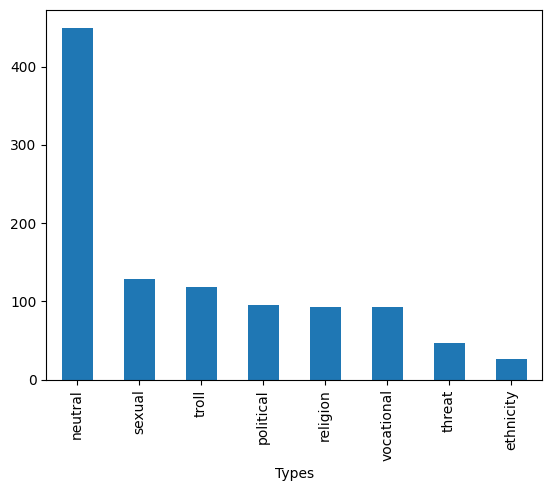

In [16]:
# Split the dataset, into train, test and eval.
# Use seed for reproducibility purpose.
from sklearn.model_selection import train_test_split
trainval_df, test_df = train_test_split(kaggle_df, test_size=0.125, random_state=42, stratify=kaggle_df.Types)
train_df, eval_df = train_test_split(trainval_df, test_size=0.080, random_state=42, stratify=trainval_df.Types)
print(f"#train items = {len(train_df)}, #val items = {len(eval_df)}, #test items = {len(test_df)}")
print("labels distribution of the test set:")
test_df.Types.value_counts().plot(kind="bar")

In [17]:
# Some text distribution exploration
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=2500, stop_words="english")

# Concatenate the texts of each class.
classese_df = kaggle_df.groupby("Types").agg({"Text":" ".join, "Label":"first", "Types":"first"}).reset_index(drop=True)

PHRASE = "phrase"
tfidf_mat = vectorizer.fit_transform(classese_df.Text.tolist())
tfidf_mat = tfidf_mat.todense()
labels = classese_df.Types.tolist()
phrases = vectorizer.get_feature_names_out().tolist()
table = {label:[] for label in labels}
for i in range(len(labels)):
    table[labels[i]] = [tfidf_mat[i,j] for j in range(len(phrases))]
tfidf_df = pd.DataFrame(table, columns=labels)
tfidf_df[PHRASE] = phrases
tfidf_df = tfidf_df[[PHRASE] + labels].reset_index(drop=True)

def get_evident_phrases(input_df: pd.DataFrame) -> pd.DataFrame:
    labels = [x for x in input_df.columns.tolist()[1:] if x != NEUTRAL]
    sorted_table = {label:[] for label in labels}
    for label in labels:
        sorted_df = input_df.sort_values(by=label, axis=0, ascending=False)
        sorted_table[label] = sorted_df[PHRASE].tolist()[:15]
    return pd.DataFrame(sorted_table)
    
tfidf_df = get_evident_phrases(tfidf_df)
print("The phrases with the highest tfidf scores of each class:\n")
tfidf_df.head(20)

The phrases with the highest tfidf scores of each class:



,ethnicity,political,religion,sexual,threat,troll,vocational
0,nigga,political,religious,sexual,police,post,job
1,nigger,public,religion,ll,received,comedy,ll
2,white,political leaders,critical,want,threat,instagram,work
3,niggers,undermines,historical,sex,threat kill,humor,economy
4,country,leaders,religious leaders,body,kidnappers,laughter,just
5,dumb,government,religious institutions,sexy,main,like,stress
6,fuck,erosion,concerned,hot,prosecution,laugh,health
7,people,exploitation,islam,fuck,stations,posts,workers
8,asking questions,neglect,muslims,unwanted,railway,reason,life balance
9,asking,national,skeptical,make,railway stations,hero,work life balance


In [18]:
# We saw above that some of the classes are characterized by pretty evident phrases.
# Let's start with a simple baseline.
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import numpy as np

vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=7500, stop_words="english")
X_Train = vectorizer.fit_transform(trainval_df.Text.tolist())
X_Train = np.asarray(X_Train.todense())

X_Test = vectorizer.transform(test_df.Text.tolist())
X_Test = np.asarray(X_Test.todense())

# Let's start with binary classification.
y_train = trainval_df.Label.map({NEUTRAL:0, BULLYING:1}).values
y_test = test_df.Label.map({NEUTRAL:0, BULLYING:1}).values

lr = LogisticRegression(random_state=42, solver='liblinear', penalty='l2')
model = lr.fit(X_Train, y_train)
y_preds = model.predict(X_Test)
print(f"Binary Classification:\n{metrics.classification_report(y_true=y_test, y_pred=y_preds, target_names=[NEUTRAL, BULLYING])}")

# Now check fine grained classification.
y_train = trainval_df.Label.map({NEUTRAL:0, BULLYING:1}).values
y_test = test_df.Label.map({NEUTRAL:0, BULLYING:1}).values

labels = [x for x in dict(trainval_df.Types.value_counts())]
label2index = {x:i for x,i in zip(labels, range(len(labels)))}
y_train = trainval_df.Types.map(label2index).values
y_test = test_df.Types.map(label2index).values
model = lr.fit(X_Train, y_train)
y_preds = model.predict(X_Test)
print(f"\n\nMulti Class Classification:\n{metrics.classification_report(y_true=y_test, y_pred=y_preds, target_names=[x for x in label2index])}")

Binary Classification:
              precision    recall  f1-score   support

     neutral       0.95      0.82      0.88       450
    bullying       0.88      0.97      0.92       601

    accuracy                           0.90      1051
   macro avg       0.91      0.89      0.90      1051
weighted avg       0.91      0.90      0.90      1051



Multi Class Classification:
              precision    recall  f1-score   support

     neutral       0.77      0.95      0.85       450
      sexual       0.83      0.79      0.81       128
       troll       0.83      0.69      0.75       119
   political       0.97      0.94      0.95        95
    religion       0.96      0.84      0.90        93
  vocational       0.77      0.55      0.64        93
      threat       0.96      0.47      0.63        47
   ethnicity       0.92      0.46      0.62        26

    accuracy                           0.82      1051
   macro avg       0.88      0.71      0.77      1051
weighted avg       0.83 

In [19]:
# The assignment defintion implies, that pipeline classification may be better than a
# single multi-class classification phase ("If harassment is detected, classify it into categories...")
# Let's use this simple baseline for checking whether pipeline classification indeed outperforms 
# the single pass classification.

# Remove all neutral items, both from the train set and from the test set.
sub_train_df = trainval_df[trainval_df.Label == BULLYING].reset_index(drop=True)
sub_test_df = test_df[test_df.Label == BULLYING].reset_index(drop=True)
labels = [x for x in dict(sub_train_df.Types.value_counts())]
label2index = {x:i for x,i in zip(labels, range(len(labels)))}

X_Train = vectorizer.fit_transform(sub_train_df.Text.tolist())
X_Train = np.asarray(X_Train.todense())

X_Test = vectorizer.transform(sub_test_df.Text.tolist())
X_Test = np.asarray(X_Test.todense())

y_train = sub_train_df.Types.map(label2index).values
y_test = sub_test_df.Types.map(label2index).values
model = lr.fit(X_Train, y_train)
y_preds = model.predict(X_Test)
print(f"\n\nMulti Class Classification, single pass, only bullying:\n{metrics.classification_report(y_true=y_test, y_pred=y_preds, target_names=[x for x in label2index])}")



Multi Class Classification, single pass, only bullying:
              precision    recall  f1-score   support

      sexual       0.73      0.93      0.82       128
       troll       0.83      0.85      0.84       119
   political       0.97      0.97      0.97        95
    religion       0.95      0.90      0.93        93
  vocational       0.71      0.72      0.72        93
      threat       0.96      0.51      0.67        47
   ethnicity       0.87      0.50      0.63        26

    accuracy                           0.83       601
   macro avg       0.86      0.77      0.80       601
weighted avg       0.84      0.83      0.83       601



In [20]:
# There indeed some improvement in performance (e.g. macro F1: 77% -> 80%, vocational: 64% -> 72%),
# but overall it's a modest rather than dramatic improvement, and some of it will be surely lost in pipeline (i.e.
# items will be detected as neutral in the first phase, and will not continue to the multi class phase).
# So I will be content, for this task, by the single phase classification.

In [21]:
# Transformer classification objects
import time
from dataclasses import dataclass
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import RobertaTokenizer
from transformers import RobertaForSequenceClassification

# The classifier
class RobertaClassifier(nn.Module):
    def __init__(self, num_labels: int, model: RobertaForSequenceClassification):
        super(RobertaClassifier, self).__init__()
        self.roberta = model.roberta
        self.dense = model.classifier.dense
        self.fc = nn.Linear(model.config.hidden_size, num_labels)

    def forward(
        self, input_ids: torch.Tensor, attention_mask: torch.Tensor
    ) -> torch.Tensor:
        x = self.roberta(input_ids, attention_mask)
        x = self.dense(x.last_hidden_state)
        logits = self.fc(x[:, 0, :])
        return logits

ATTENTION_MASK = "attention_mask"
INPUT_IDS = "input_ids"
LABEL = "label"
TEXT = "Text"

# Dataset
class RobertaDataset(Dataset):
    def __init__(self, df: pd.DataFrame, target_field: str, label2index: dict, tokenizer: RobertaTokenizer):
        super(RobertaDataset, self).__init__()
        tokenized_texts = [
            tokenizer(
                text,
                padding="max_length",
                max_length=tokenizer.model_max_length,
                truncation=True,
                return_tensors="pt",
            )
            for text in df[TEXT]
        ]
        self.labels = df[target_field].map(label2index).values.tolist()
        self.tokens = [item[INPUT_IDS].squeeze() for item in tokenized_texts]
        self.masks = [item[ATTENTION_MASK].squeeze() for item in tokenized_texts]

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, index):
        tokens = self.tokens[index]
        mask = self.masks[index]
        label = torch.tensor(self.labels[index])
        return tokens, mask, label

PREDICTIONS = "predictions"
TRUES = "trues"
DURATION = "duration"
ACCURACY = "accuracy"
MACRO_F1 = "macro_f1"

def predict(model: nn.Module, dl: DataLoader) -> dict:
    y_preds = []
    y_trues = []
    start_time = time.time()
    model = model.eval()
    for batch in dl:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = (
            input_ids.to(device),
            attention_mask.to(device),
            labels.to(device),
        )
        with torch.no_grad():
            logits = model(input_ids=input_ids, attention_mask=attention_mask)

        y_preds += torch.argmax(logits, dim=1).tolist()
        y_trues += labels.tolist()

    duration = time.time() - start_time
    acc = metrics.accuracy_score(y_true=y_trues, y_pred=y_preds)
    f1 = metrics.f1_score(y_true=y_trues, y_pred=y_preds, average="macro")
    return {
        DURATION: duration,
        ACCURACY: acc,
        MACRO_F1: f1,
        PREDICTIONS: y_preds,
        TRUES: y_trues
    }

LEARNIN_RATE = 1e-5
MAX_EPOCHS = 20
MODEL_NAME = "roberta-large"
BETA_ONE = 0.0
BETA_TWO = 0.98
ADAM_EPS = 0.00000001
BATCH_SIZE = 32
EVAL = "eval"
TRAIN = "train"
TEST = "test"
EARLY_STOP_PATIENCE = 3

@dataclass
class PendingStats:
    best_val_score: float = 0
    best_val_epoch: int = -1
    best_test_score: float = 0
    best_test_epoch: int = -1
    best_induced_score: float = 0
    best_induced_epoch: int = -1

# The training procedure.
# The test set is used only for logging and for
# improving efficiency and convenience of
# the procedure.
def train_model(
    train_df: pd.DataFrame,
    eval_df: pd.DataFrame,
    test_df: pd.DataFrame,
    target_col: str,
    fraction: float=-1) -> PendingStats:
    start_train_time = time.time()
    print(f"\tGPU status: {device}")
    
    labels = [x for x in dict(train_df[target_col].value_counts())]
    label2index = {x:i for x,i in zip(labels, range(len(labels)))}
    ind2label = {x[1]: x[0] for x in label2ind.items()}
    
    model = RobertaForSequenceClassification.from_pretrained(
        MODEL_NAME,
        label2id=label2ind,
        id2label=ind2label,
        ignore_mismatched_sizes=True,
    )
    tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)
    model = RobertaClassifier(num_labels=len(label2ind), model=model)
    model = model.to(device=device)

    optimizer = optim.Adam(
        model.parameters(),
        self.learning_rate,
        betas=(BETA_ONE, BETA_TWO),
        eps=ADAM_EPS,
    )
    loss_func = nn.CrossEntropyLoss()

    if (fraction > 0) and (fraction < 1):
        rands = [np.random.random() for i in range(len(train_df))]
        train_df = train_df[[r < fraction for r in rands]].copy()
        
    train_dl = DataLoader(
        dataset=RobertaDataset(df=train_df, target_field=target_col, label2index=label2ind, tokenizer=tokenizer),
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=False,
    )
    
    eval_dl = DataLoader(
        dataset=RobertaDataset(df=eval_df, target_field=target_col, label2index=label2ind, tokenizer=tokenizer),
        batch_size=BATCH_SIZE,
        shuffle=False,
        drop_last=False,
    )

    test_dl = DataLoader(
        dataset=RobertaDataset(df=test_df, target_field=target_col, label2index=label2ind, tokenizer=tokenizer),
        batch_size=BATCH_SIZE,
        shuffle=False,
        drop_last=False,
    )

    print("start training loops. #max epochs = " + str(MAX_EPOCHS))
    header = f"{'Epoch':^7} | {'Train Loss':^11} | {'Train Acc:':^10} | "
    header += f"{'Train F1':^10} | {'Eval F1':^10} | {'Test F1':^10} | "
    header += f"{'Epoch Time':^10} | {'Best Eval':^10} | {'Best Induced':^13} | "
    header += f"{'Best Test':^10}"
    print(header)

    stats = train_aux.PendingStats()
    num_no_imp = 0
    start_time = time.time()
    for i in range(MAX_EPOCHS):
        total_loss = 0
        model = model.train()
        epoch_start_time = time.time()
        for batch in train_dl:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = (input_ids.to(device), attention_mask.to(device), labels.to(device),)

            optimizer.zero_grad()
            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_func(logits, labels)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        results = {EVAL: predict(model=model, dl=eval_dl), TRAIN: predict(model=model, dl=train_dl), TEST: predict(model=model, dl=test_dl),}
        mean_loss = total_loss / self.eval_steps
        duration = time.time() - epoch_start_time
        
        if results[EVAL][MACRO_F1] > stats.best_val_score:
            num_no_imp = 0
            stats.best_val_score = results[EVAL][MACRO_F1]
            stats.best_val_epoch = i
            if results[TEST][MACRO_F1] > stats.best_induced_score:
                stats.best_induced_score = results[TEST][MACRO_F1]
                stats.best_induced_epoch = i
        else:
            num_no_imp += 1

        if results[TEST][MACRO_F1] > stats.best_test_score:
            stats.best_test_score = results[TEST][MACRO_F1]
            stats.best_test_epoch = i
            
        epoch_line = f"{i:^7} | {mean_loss:^11.5} | {results[TRAIN][ACCURACY]:^10.4} | "
        epoch_line += f"{results[TRAIN][MACRO_F1]:^10.4} | {results[EVAL][MACRO_F1]:^10.4} | {results[TEST][MACRO_F1]:^10.4} | "
        epoch_line += f"{duration:^10.1} | {stats.best_val_score:^10.4} | {stats.best_induced_score:^10.4} | "
        epoch_line += f"{stats.best_test_socre:^10.4}"
        print(epoch_line)

        if num_no_imp >= EARLY_STOP_PATIENCE:
            break

    print("Train End!")
    print(f"train time: {time.time() - start_time:.2f}\n")
    print(f"best val: step={stats.best_val_step}, f1={stats.best_val_score:.4f}\n")
    print(f"best induced: step={stats.best_induced_step}, f1={stats.best_induced_score:.4f}\n")
    print(f"best test: step={stats.best_test_step}, f1={stats.best_test_socre:.4f}\n")

    return stats
print("Done establish transformer objects")

Done establish transformer objects
